Code from previous section

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
import copy
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

def get_spectrum(pars,n,lmax=2000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    
    return tt[2:n+2]	# Getting rid of first to zero elements and resizing to data size

def chi_sq(data,y,err):
	# X,data are the given data, y is obtained from fit using 'pars'
	return np.sum((data-y)**2/err**2)

def f(params,n,dx):
	y=get_spectrum(params,n)
	derivs=np.zeros([n,len(params)])
	for i in range(len(params)):		
		par = copy.deepcopy(params)
		par[i] += dx[i]
		y2=get_spectrum(par,n)
		par[i] -= 2*dx[i]
		y1=get_spectrum(par,n)
		derivs[:,i]=(y2-y1)/(2*dx[i])
	return y,derivs

def newton(f,pars,delete_par,y,Ninv,dm,lmd):
	print('Initial par: ',pars)
	y_pred,derivs=f(pars,len(y),dm)
	derivs = np.delete(derivs, delete_par, axis=1)
	resid=y-y_pred #data minus current model
	rhs=derivs.T@(Ninv@resid)
	lhs=(derivs.T@Ninv@derivs)
	step=np.linalg.inv(lhs*(np.eye(len(derivs[0]))*(1.0+lmd)))@rhs
	for i in delete_par:
		step = np.insert(step, i, 0.0)
	m=pars+step
	print('Step ',step)
	print('New Params: ',m)
	return m,step,lhs


def LM(pars_cur,y_data,error_data,delete_index,f):

	n = len(y_data)
	N = np.zeros((n,n))
	np.fill_diagonal(N,error_data)
	Ninv=np.linalg.inv(N)
	y_cur = get_spectrum(pars_cur,n)
	chi_sq_curr = chi_sq(y_data,y_cur,error_data)
	dm = pars_cur/1000.0
	lmd = 0.0 
	chi_sq_step = []
	lhs_cur = []
	for iter in range(1000):
		print('\n(Iteration, lambda)= ',[iter,lmd])
		pars_new,step,lhs = newton(f,pars_cur,delete_index,y_data,Ninv,dm,lmd)
		y_pred = get_spectrum(pars_new,n)
		chi_sq_new = chi_sq(y_data,y_pred,error_data)
		if chi_sq_new < chi_sq_curr:
			chi_sq_step.append(chi_sq_new)
			pars_cur = pars_new
			lhs_cur = lhs
			y_cur = get_spectrum(pars_cur,n)
			chi_sq_curr = chi_sq_new
			lmd = lmd**0.5
			if lmd < 1.1:
				lmd = 0.0
		else:
			print('Chi_sq- new:',chi_sq_new,' curr:',chi_sq_curr)
			if lmd == 0:	
				lmd += 2.0
			else:
				lmd = lmd*2	
		if True:
			print('\n\nFinal parameter values: \n',pars_cur)
			if len(lhs_cur)==0:
				lhs_cur = lhs
			break
	return pars_cur, lhs_cur, chi_sq_step

Function for runnin Markov-chain Monte carlo. In addition to its basic working it accepts covariance matrix **corr_mat** which it uses to calculate correlated step.

In [3]:
def run_mcmc(pars,data,corr_mat,chifun,file,nstep=5000):
	file = open(file,'a')      #Storign chain into file
	npar=len(pars)
	chain=np.zeros([nstep,npar])
	chivec=np.zeros(nstep)
	y_pred = get_spectrum(pars,len(data[0]))
	chi_cur=chifun(data[1],y_pred,data[2])
	L = np.linalg.cholesky(corr_mat)*0.7	#Performing cholesky on covariance matrix to generate correlated steps. Factor of 0.7 is for scaling down the step size for required acceptance (~25-30%)
	for i in range(nstep):
		pars_trial=pars+L@np.random.randn(npar) #Modifying/taking step 
		print('\nStep ',i,'  Trial parameter: \n',pars_trial)
		if pars_trial[3]<0.0:	#Skipping over steps with negative optical depth
			continue
		y_new = get_spectrum(pars_trial,len(data[0]))		
		chi_trial=chifun(data[1],y_new,data[2])
		#we now have chi^2 at our current location
		#and chi^2 in our trial location. decide if we take the step
		accept_prob=np.exp(-0.5*(chi_trial-chi_cur))
		if np.random.rand(1)<accept_prob: #accept the step with appropriate probability
			pars=pars_trial
			chi_cur=chi_trial
		chain[i]=pars 			# Saving step data, with or without any change from this iteration
		chivec[i]=chi_cur
		file.write(str(chivec[i])+' '+str(chain[i,0])+' '+str(chain[i,1])+' '+
			 str(chain[i,2])+' '+str(chain[i,3])+' '+str(chain[i,4])+' '+str(chain[i,5])+' '+'\n')
	file.close()
	# Returning chain data also with chi-sq at each step
	return chain,chivec

Initializing. Running 1 step of newtons method using info we get from previous question to obtain the curvature at those parameter values.

In [ ]:
pars_cur = np.asarray([7.10138302e+01,2.22880120e-02,1.07300854e-01,5.06943972e-02,1.99554627e-09,9.73364395e-01])
wmap=np.loadtxt('WMAP_data.txt')
error_data = wmap[:,2]
y_data = wmap[:,1]

delete_index = []
pars_cur, lhs, chi = LM(pars_cur,y_data,error_data,delete_index,f)


Using the parameters we obtained earlier and the inverse of **lhs** to provide covariance matrix and seeding the **mcmc** function. To start of I run a short chain which then will be used to seed the second long chain.

In [ ]:
# Using above results to seed mcmc
data=wmap.T
file = 'chain_data.txt'
chain,chivec=run_mcmc(pars_cur,data,np.linalg.inv(lhs),chi_sq,file,nstep=5000)

In [4]:
# Loading data back from file (helps get rid of steps where optical depth went negative) 
chain  = []
chivec = []
file = open('chain_data.txt','r')
for t in file:
	t = np.asarray(t.strip().split(),dtype='float')
	chivec.append(t[0])
	chain.append(t[1:])
file.close()	
chain = np.asarray(chain)	
chivec = np.asarray(chivec)

Seeding a longer chain using above data

In [ ]:
# Running a long chain
delt = (chain).copy()
pars_guess=np.median(delt,axis=0)
for i in range(delt.shape[1]):
    delt[:,i]=delt[:,i]-pars_guess[i]
mycov=delt.T@delt/delt.shape[0]

file = 'chain_data_final.txt'
chain2,chivec2=run_mcmc(pars_guess,data,mycov,chi_sq,file,nstep=20000)

In [37]:
#For loading the data
chain2  = []
chivec2 = []
file = open('chain_data_final.txt','r')
for t in file:
	t = np.asarray(t.strip().split(),dtype='float')
	chivec2.append(t[0])
	chain2.append(t[1:])
chain2 = np.asarray(chain2)	
chivec2 = np.asarray(chivec2)
file.close()

#### Parameter values

In [38]:
pars_cur=np.median(chain2,axis=0)
delt = (chain2).copy()
for i in range(delt.shape[1]):
    delt[:,i]=delt[:,i]-pars_cur[i]
mycov=delt.T@delt/delt.shape[0]
par_errs=np.abs(np.sqrt(np.diag(mycov)))
print('Current parameter values:')
for i in range(6):
    print('Parameter'+str(i)+' : ',pars_cur[i],'\t+/-',par_errs[i])

Current parameter values:
Parameter0 :  71.17880984971593 	+/- 3.4606606726215383
Parameter1 :  0.022944739102414256 	+/- 0.0007292810543012528
Parameter2 :  0.11060039276633393 	+/- 0.0066226390315339626
Parameter3 :  0.1047601704360573 	+/- 0.057942820203722774
Parameter4 :  2.2746308813106766e-09 	+/- 2.499692518448387e-10
Parameter5 :  0.9842049548183078 	+/- 0.021754897645012646


***
Now to check for convergence, I do that by calculating the power spectrum of the chain

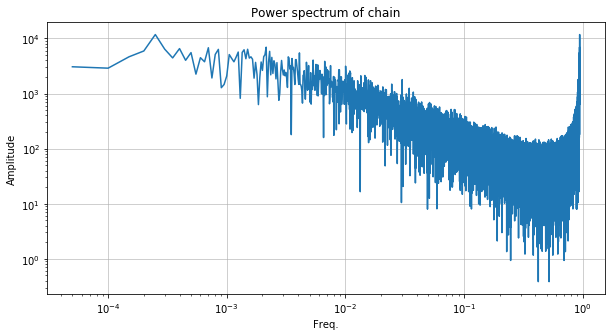

number of Independant samples =  40.0
Error in the means:  0.15811388300841897 *sigma


In [36]:
freq = np.fft.fft(chain2[:,0])

plt.figure(figsize=(10,5))      
plt.title('Power spectrum of chain')
plt.xlabel('Freq.')
plt.grid(alpha=0.75)
plt.ylabel('Amplitude')
plt.xscale('log')
plt.yscale('log')
plt.plot([i/20000.0 for i in range(1,len(freq))],abs(freq[1:]))
plt.show()

#Knee appears somewhere near 2x10^-3 which means we have 1 independant sample every 500 points, which is ~200 independant sample.
knee = 2*10**(-3)
freq_indep_samples = 1/knee
no_indep_samples = 20000/freq_indep_samples
print('number of Independant samples = ', no_indep_samples)
print('Error in the means: ',1/(no_indep_samples)**0.5,'*sigma')

***
The above plot shows that the sepctrum flattens out at lower freq indicating independant samples at large distance which tells us that the chain **converged**. But the size of the chain isnt large enough to restrain the error in the mean. The knee appears near 2x10^(-3) which corresponds roughly to 1 independant sample for every 500 points. 

But the 20k points in the chain, we get only about 40 independant samples which put out mean error somewhere near, $Error = \sigma/7$.

(I agree this isnt very good, but depending on accuracy requirements we can always reduce error further by having more samples.) 

##### Extra

We can also check out the correlation between parameters, specifically for tau since we made a dedcution in previous question that it is strongly correlated and following plots show just that.

***
Although all of these combinations show some degree of correlation, the **optical density** is strongly correlated with the **primordial amplitude of fuctuations** (4th plot) thus confirming our earlier statement.
***

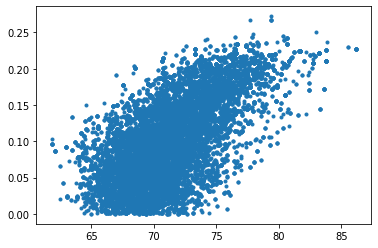

In [48]:
plt.plot(chain2[:,0],chain2[:,3],'.')

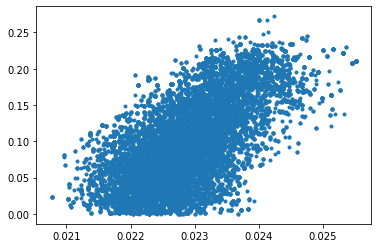

In [43]:
plt.plot(chain2[:,1],chain2[:,3],'.')

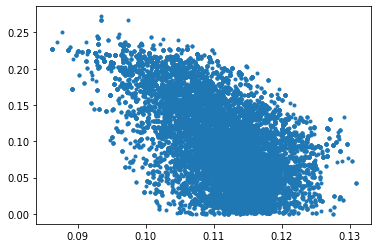

In [44]:
plt.plot(chain2[:,2],chain2[:,3],'.')

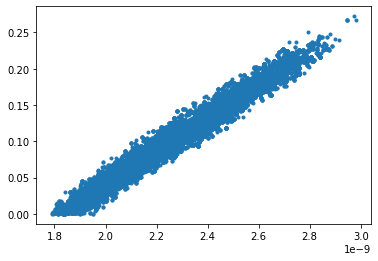

In [45]:
plt.plot(chain2[:,4],chain2[:,3],'.')

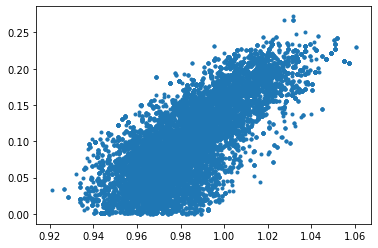

In [46]:
plt.plot(chain2[:,5],chain2[:,3],'.')